<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch15_sequences_rnns_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 15 — Processing Sequences Using RNNs and CNNs

## 1) Summary
This chapter is about **modeling sequential data** (text, time series, audio-like signals) using:
- **Recurrent Neural Networks (RNNs)**: SimpleRNN, LSTM, GRU, and Bidirectional variants.
- **1D Convolutional Networks (Conv1D)**: strong baselines for many sequence tasks.
- Practical dataset pipelines for sequences (padding, masking, windowing time series with `tf.data`).

In this notebook I reproduce the typical workflows:
1. **Text sequence classification** (IMDB sentiment):
   - baseline RNN,
   - improved LSTM/GRU,
   - bidirectional RNN,
   - Conv1D text model.
2. **Time series forecasting** (synthetic series):
   - build a windowed dataset,
   - train a Dense baseline,
   - train an RNN forecaster,
   - train a Conv1D forecaster,
   - compare results with a clean evaluation metric (MAE).

Key idea:
Sequence models must learn patterns across time/positions. RNNs do it via recurrence (state),
while Conv1D does it via local temporal filters (often faster and easier to train).

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))

TensorFlow: 2.19.0
GPU available: True


## 2) Concept Notes (what I keep in mind)

### 2.1 What makes sequence data special?
The order matters:
- text: word order changes meaning,
- time series: the next value depends on prior values,
- audio: waveform patterns depend on local temporal structure.

### 2.2 RNN intuition (stateful processing)
An RNN processes one timestep at a time:
- input x(t)
- hidden state h(t) = f(h(t-1), x(t))
This lets the network carry information forward through time.

### 2.3 LSTM / GRU
Simple RNNs can struggle with long-term dependencies (vanishing gradients).
LSTM and GRU introduce gating mechanisms to keep/forget information more reliably.

### 2.4 Bidirectional RNN
For tasks where the whole sequence is available (e.g., text classification),
a bidirectional RNN reads the sequence forward and backward, often improving accuracy.

### 2.5 Conv1D for sequences
Conv1D uses small temporal filters to detect local patterns (n-grams in text, short-term trends in time series).
It is:
- parallelizable (faster than RNNs),
- a strong baseline for many sequence problems.

### 2.6 Masking and padding
For text, sequences have variable length. We usually:
- pad to a fixed length,
- use masking (or `mask_zero=True` in Embedding) so padding does not affect learning.

# Part A — Text Sequence Classification (IMDB Sentiment)

## 3) Load IMDB dataset
IMDB dataset (Keras built-in):
- binary sentiment classification (positive/negative)
- sequences of word indices (integers)
- we limit vocabulary size to keep training fast and memory stable in Colab.

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000  # keep top 20k words
max_len = 200       # truncate/pad to 200 tokens

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

X_train = pad_sequences(X_train, maxlen=max_len, padding="pre", truncating="pre")
X_test  = pad_sequences(X_test,  maxlen=max_len, padding="pre", truncating="pre")

# Create a validation split
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

X_train.shape, X_valid.shape, X_test.shape

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


((20000, 200), (5000, 200), (25000, 200))

## 4) Training helper + plotting
To keep experiments consistent, I use a shared helper:
- compile
- fit
- evaluate
- plot curves

In [3]:
def compile_fit_eval(model, X_train, y_train, X_valid, y_valid, X_test, y_test,
                     optimizer, epochs=3, batch_size=128, verbose=1):
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        verbose=verbose
    )
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    return history, float(test_acc)

def plot_history(history, title):
    df = pd.DataFrame(history.history)
    df[["loss", "val_loss"]].plot(figsize=(8, 4), grid=True, title=title + " — loss")
    plt.show()
    df[["accuracy", "val_accuracy"]].plot(figsize=(8, 4), grid=True, title=title + " — accuracy")
    plt.ylim(0, 1)
    plt.show()

## 5) Baseline: Embedding + SimpleRNN
Model:
- Embedding(vocab_size, embedding_dim, mask_zero=True)
- SimpleRNN(units)
- Dense(1, sigmoid)

Notes:
- `mask_zero=True` tells Keras to ignore padded zeros.
- SimpleRNN is the simplest recurrent layer; it may struggle on longer sequences.

In [4]:
embedding_dim = 32

rnn_baseline = keras.models.Sequential([
    keras.layers.Input(shape=(max_len,)),
    keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1, activation="sigmoid")
])

rnn_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 32)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,113 (2.45 MB)

 Trainable params: 642,113 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.5665 - loss: 0.6704 - val_accuracy: 0.7872 - val_loss: 0.4783
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8367 - loss: 0.3814 - val_accuracy: 0.8126 - val_loss: 0.4094
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9001 - loss: 0.2617 - val_accuracy: 0.8360 - val_loss: 0.4048


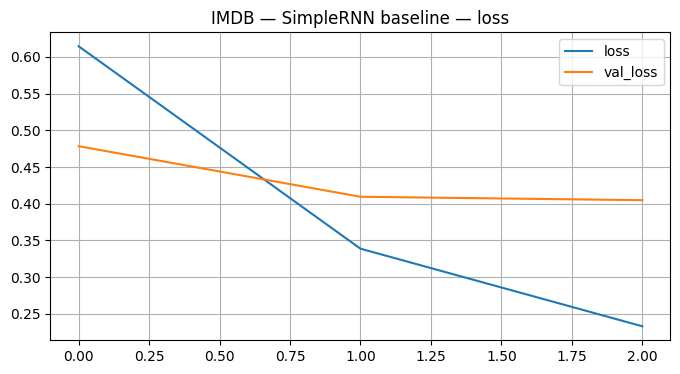

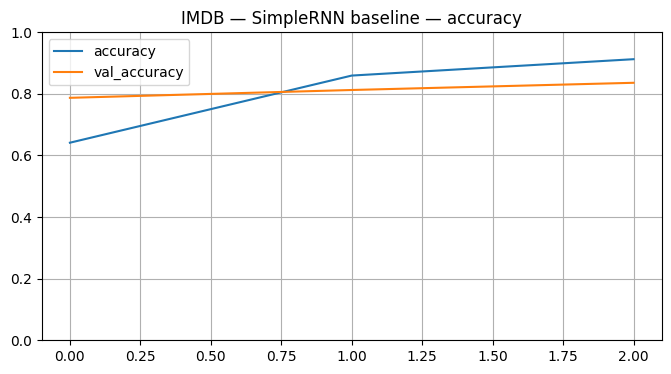

0.8349599838256836

In [5]:
hist_rnn, acc_rnn = compile_fit_eval(
    rnn_baseline,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_rnn, "IMDB — SimpleRNN baseline")
acc_rnn

## 6) LSTM model
LSTM usually performs better than SimpleRNN on text because it handles longer dependencies more reliably.

In [6]:
lstm_model = keras.models.Sequential([
    keras.layers.Input(shape=(max_len,)),
    keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation="sigmoid")
])

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 32)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,897 (2.54 MB)

 Trainable params: 664,897 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9420 - loss: 0.1760 - val_accuracy: 0.8432 - val_loss: 0.4466
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9594 - loss: 0.1275 - val_accuracy: 0.8558 - val_loss: 0.4300
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9547 - loss: 0.1316 - val_accuracy: 0.8474 - val_loss: 0.4213


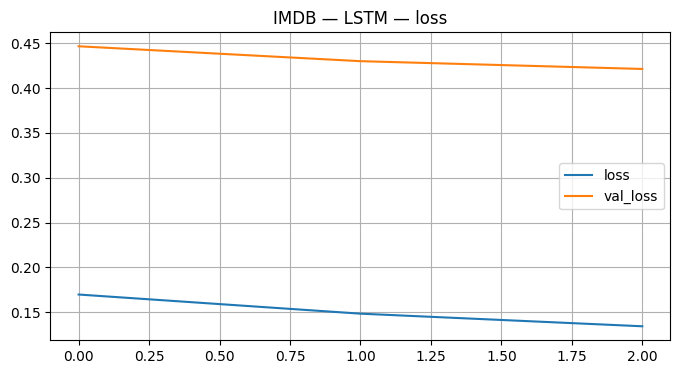

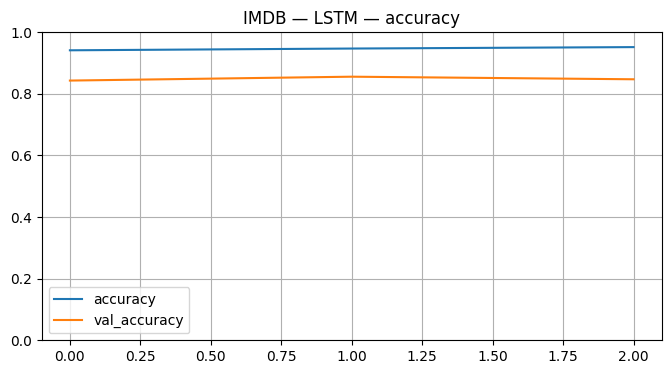

LSTM Test Accuracy: 0.8233


In [19]:
hist_lstm, acc_lstm = compile_fit_eval(
    lstm_model,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_lstm, "IMDB — LSTM")
print(f"LSTM Test Accuracy: {acc_lstm:.4f}")

## 7) GRU model
GRU is a lighter alternative to LSTM (fewer parameters) and often performs similarly.

In [20]:
gru_model = keras.models.Sequential([
    keras.layers.Input(shape=(max_len,)),
    keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
    keras.layers.GRU(64),
    keras.layers.Dense(1, activation="sigmoid")
])

gru_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 32)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,881 (2.51 MB)

 Trainable params: 658,881 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6230 - loss: 0.6222 - val_accuracy: 0.8502 - val_loss: 0.3610
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8744 - loss: 0.3079 - val_accuracy: 0.8610 - val_loss: 0.3850
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9139 - loss: 0.2324 - val_accuracy: 0.8382 - val_loss: 0.4247


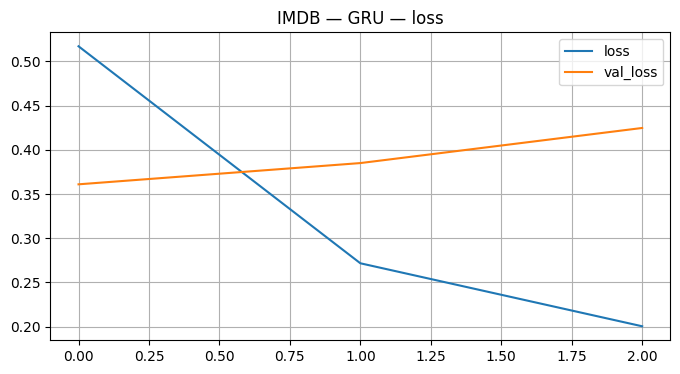

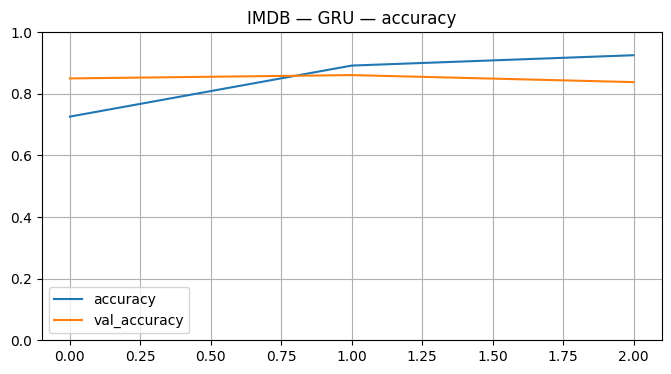

0.8201199769973755

In [21]:
hist_gru, acc_gru = compile_fit_eval(
    gru_model,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_gru, "IMDB — GRU")
acc_gru

## 8) Bidirectional LSTM
For text classification, the entire sequence is available, so reading from both directions often helps.

In [22]:
bilstm_model = keras.models.Sequential([
    keras.layers.Input(shape=(max_len,)),
    keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(1, activation="sigmoid")
])

bilstm_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 32)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,793 (2.63 MB)

 Trainable params: 689,793 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6739 - loss: 0.5877 - val_accuracy: 0.8422 - val_loss: 0.3770
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8811 - loss: 0.2977 - val_accuracy: 0.8654 - val_loss: 0.3285
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9271 - loss: 0.2063 - val_accuracy: 0.8666 - val_loss: 0.3355


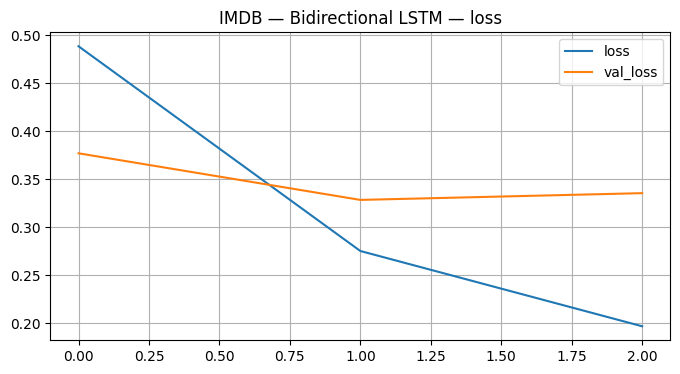

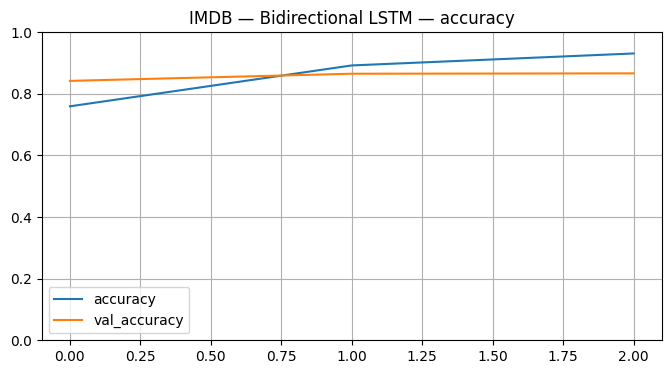

0.8432400226593018

In [23]:
hist_bilstm, acc_bilstm = compile_fit_eval(
    bilstm_model,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_bilstm, "IMDB — Bidirectional LSTM")
acc_bilstm

## 9) Conv1D for text (CNN sequence model)
A common and efficient text classifier:
Embedding → Conv1D → GlobalMaxPool → Dense

Intuition:
- Conv1D filters act like trainable n-gram detectors.
- GlobalMaxPooling picks the strongest signal anywhere in the sequence.

In [24]:
cnn_text_model = keras.models.Sequential([
    keras.layers.Input(shape=(max_len,)),
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Conv1D(filters=64, kernel_size=7, activation="relu", padding="same"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=7, activation="relu", padding="same"),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid"),
])

cnn_text_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 200, 32)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 200, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 64)        │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,361 (2.62 MB)

 Trainable params: 687,361 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5626 - loss: 0.6614 - val_accuracy: 0.8096 - val_loss: 0.4192
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8451 - loss: 0.3571 - val_accuracy: 0.8426 - val_loss: 0.3879
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9287 - loss: 0.1956 - val_accuracy: 0.8392 - val_loss: 0.4698


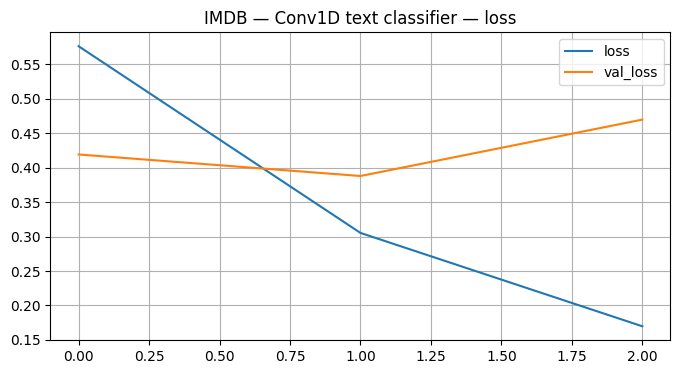

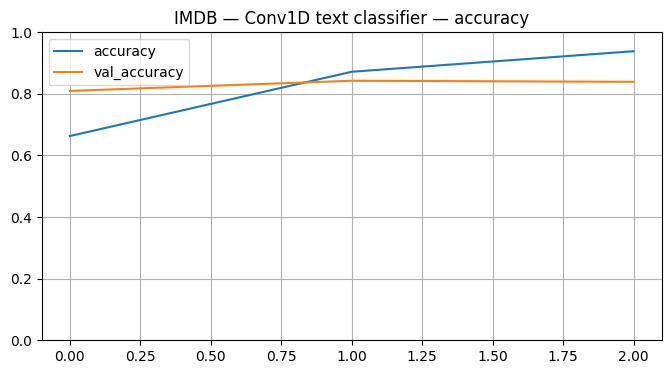

0.8270000219345093

In [25]:
hist_cnn_text, acc_cnn_text = compile_fit_eval(
    cnn_text_model,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_cnn_text, "IMDB — Conv1D text classifier")
acc_cnn_text

## 10) Quick comparison table (IMDB)
This is a small comparison based on the same training budget (few epochs).
The goal is to document relative behavior, not to fully optimize accuracy.

In [26]:
imdb_results = pd.DataFrame([
    {"model": "SimpleRNN", "test_accuracy": acc_rnn},
    {"model": "LSTM", "test_accuracy": acc_lstm},
    {"model": "GRU", "test_accuracy": acc_gru},
    {"model": "BiLSTM", "test_accuracy": acc_bilstm},
    {"model": "Conv1D", "test_accuracy": acc_cnn_text},
]).sort_values("test_accuracy", ascending=False)

imdb_results

,model,test_accuracy
3,BiLSTM,0.84324
0,SimpleRNN,0.83496
4,Conv1D,0.82700
1,LSTM,0.82332
2,GRU,0.82012


# Part B — Time Series Forecasting (Synthetic Series)

## 11) Why synthetic time series?
For this chapter’s learning goal, synthetic series are useful because:
- we control the signal + noise,
- we can test forecasting pipelines quickly,
- we can focus on modeling patterns (trend/seasonality/noise) rather than data cleaning.

I implement a standard windowing pipeline:
- create a long series,
- split into train/valid/test by time,
- build `(window -> next_value)` datasets with `tf.data`.

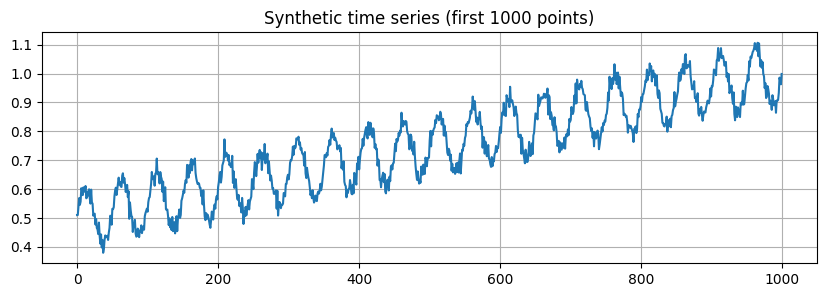

In [27]:
def generate_time_series(n_steps=10000, seed=42):
    rng = np.random.RandomState(seed)
    time = np.arange(n_steps, dtype=np.float32)
    # Trend + seasonality + noise
    trend = time * 0.0005
    seasonal = 0.1 * np.sin(2 * np.pi * time / 50)
    noise = 0.02 * rng.randn(n_steps).astype(np.float32)
    series = 0.5 + trend + seasonal + noise
    return time, series

time, series = generate_time_series(n_steps=12000)
plt.figure(figsize=(10, 3))
plt.plot(time[:1000], series[:1000])
plt.title("Synthetic time series (first 1000 points)")
plt.grid(True)
plt.show()

## 12) Train/valid/test split by time
For time series, I must avoid shuffling across time when creating splits.
I split by indices:
- train: earliest segment
- valid: middle segment
- test: latest segment

In [28]:
n = len(series)
train_end = int(n * 0.7)
valid_end = int(n * 0.85)

series_train = series[:train_end]
series_valid = series[train_end:valid_end]
series_test  = series[valid_end:]

len(series_train), len(series_valid), len(series_test)

(8400, 1800, 1800)

## 13) Windowed dataset (tf.data)
I build examples as:
- input: a window of length `window_size`
- target: next value after the window

This is the standard supervised framing for one-step-ahead forecasting.

In [29]:
def make_window_dataset(series, window_size, batch_size=64, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.shuffle(shuffle_buffer, seed=42)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

window_size = 30
batch_size = 64

train_ds = make_window_dataset(series_train, window_size, batch_size=batch_size)
valid_ds = make_window_dataset(series_valid, window_size, batch_size=batch_size)
test_ds  = make_window_dataset(series_test,  window_size, batch_size=batch_size)

for Xb, yb in train_ds.take(1):
    print(Xb.shape, yb.shape)

(64, 30) (64,)


## 14) Baseline forecaster (Dense)
A minimal baseline:
- input shape: (window_size,)
- Dense layers
This often works reasonably well for simple signals, but it cannot easily learn shift-invariant patterns like Conv1D.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


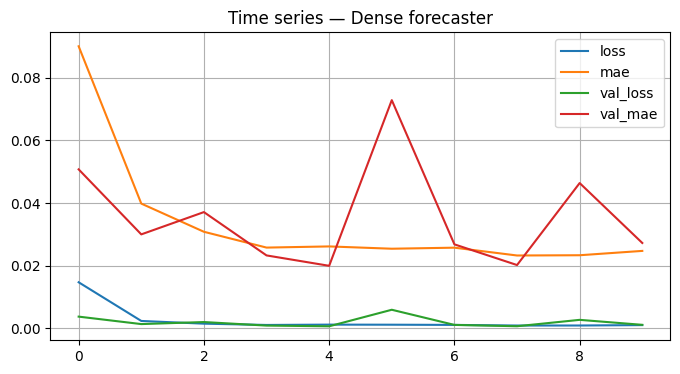

In [30]:
dense_forecaster = keras.models.Sequential([
    keras.layers.Input(shape=(window_size,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

dense_forecaster.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
)

hist_dense = dense_forecaster.fit(train_ds, validation_data=valid_ds, epochs=10, verbose=0)
pd.DataFrame(hist_dense.history).plot(figsize=(8, 4), grid=True, title="Time series — Dense forecaster")
plt.show()

In [31]:
dense_eval = dense_forecaster.evaluate(test_ds, verbose=0)
dense_eval

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.0013830162351951003, 0.031157882884144783]

## 15) RNN forecaster (SimpleRNN)
For forecasting, an RNN reads the window as a sequence:
- input shape: (window_size, 1)
- the RNN output summarizes the sequence
- final Dense predicts next value

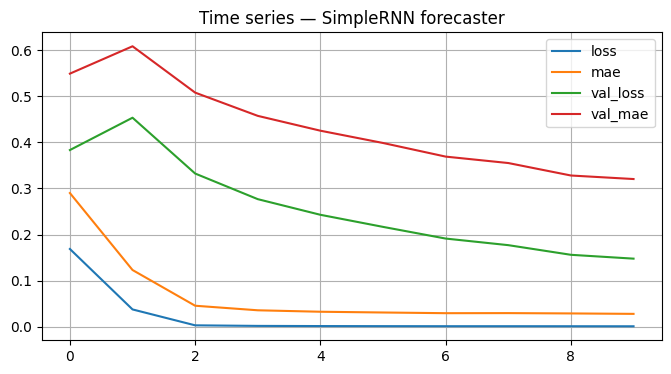

In [32]:
# Reshape window input to (window_size, 1) using a Lambda layer
rnn_forecaster = keras.models.Sequential([
    keras.layers.Input(shape=(window_size,)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)
])

rnn_forecaster.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
)

hist_rnn_ts = rnn_forecaster.fit(train_ds, validation_data=valid_ds, epochs=10, verbose=0)
pd.DataFrame(hist_rnn_ts.history).plot(figsize=(8, 4), grid=True, title="Time series — SimpleRNN forecaster")
plt.show()

In [33]:
rnn_eval = rnn_forecaster.evaluate(test_ds, verbose=0)
rnn_eval

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[1.673234224319458, 1.2527731657028198]

## 16) Conv1D forecaster
Conv1D often works well for time series because it detects local temporal patterns.
Model:
- expand dims to (window_size, 1)
- Conv1D layers
- GlobalAveragePooling
- Dense output

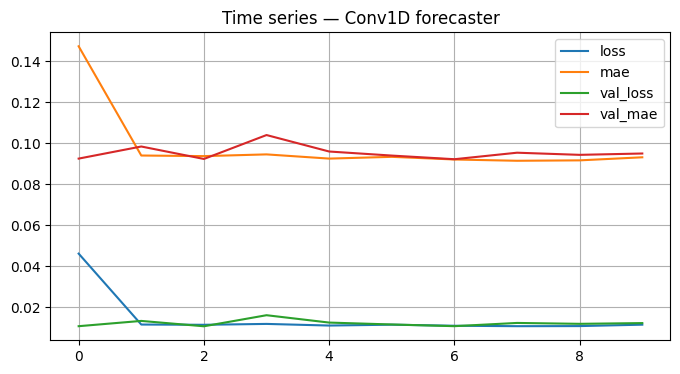

In [34]:
cnn_forecaster = keras.models.Sequential([
    keras.layers.Input(shape=(window_size,)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    keras.layers.Conv1D(filters=32, kernel_size=5, padding="causal", activation="relu"),
    keras.layers.Conv1D(filters=32, kernel_size=5, padding="causal", activation="relu"),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1)
])

cnn_forecaster.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
)

hist_cnn_ts = cnn_forecaster.fit(train_ds, validation_data=valid_ds, epochs=10, verbose=0)
pd.DataFrame(hist_cnn_ts.history).plot(figsize=(8, 4), grid=True, title="Time series — Conv1D forecaster")
plt.show()

In [35]:
cnn_eval = cnn_forecaster.evaluate(test_ds, verbose=0)
cnn_eval

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.014073596335947514, 0.09906743466854095]

## 17) Compare forecasting MAE
Lower MAE means better average absolute error on the test set.

In [36]:
ts_results = pd.DataFrame([
    {"model": "Dense", "test_mae": float(dense_eval[1])},
    {"model": "SimpleRNN", "test_mae": float(rnn_eval[1])},
    {"model": "Conv1D", "test_mae": float(cnn_eval[1])},
]).sort_values("test_mae")
ts_results

,model,test_mae
0,Dense,0.031158
2,Conv1D,0.099067
1,SimpleRNN,1.252773


## 18) Visualize predictions on a small test segment
I plot a short segment of the test series and compare model predictions (one-step ahead).

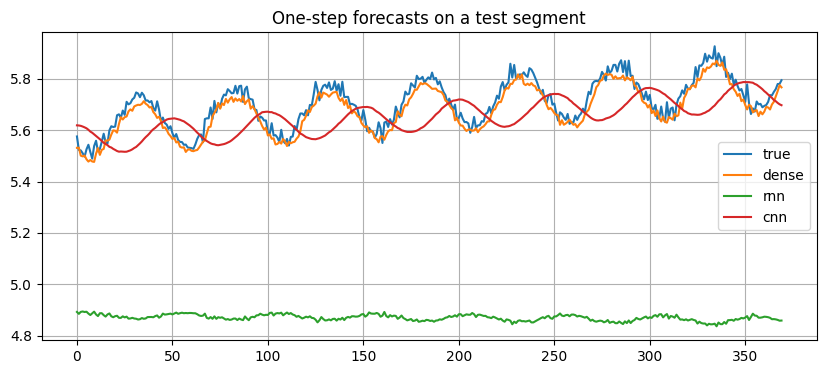

In [37]:
# Create a small helper to produce predictions aligned with time indices
def forecast_on_series(model, series, window_size):
    preds = []
    for i in range(len(series) - window_size):
        window = series[i:i+window_size][np.newaxis, ...]
        pred = model.predict(window, verbose=0)[0, 0]
        preds.append(pred)
    return np.array(preds, dtype=np.float32)

segment = series_test[:400]  # small segment
pred_dense = forecast_on_series(dense_forecaster, segment, window_size)
pred_rnn   = forecast_on_series(rnn_forecaster, segment, window_size)
pred_cnn   = forecast_on_series(cnn_forecaster, segment, window_size)

true = segment[window_size:]

plt.figure(figsize=(10, 4))
plt.plot(true, label="true")
plt.plot(pred_dense, label="dense")
plt.plot(pred_rnn, label="rnn")
plt.plot(pred_cnn, label="cnn")
plt.title("One-step forecasts on a test segment")
plt.grid(True)
plt.legend()
plt.show()

## 19) Takeaways
- Sequence tasks require models that can capture patterns across positions/time.
- For text:
  - SimpleRNN is a baseline but often weaker than LSTM/GRU.
  - Bidirectional RNNs often help for classification where the whole sequence is available.
  - Conv1D is a strong, efficient baseline for text (n-gram detector intuition).
- For time series:
  - Build supervised datasets via windowing.
  - Dense, RNN, and Conv1D are all valid; Conv1D often trains fast and captures local temporal patterns well.
- The best model depends on:
  - sequence length,
  - dependency range (short vs long),
  - compute constraints,
  - whether future context is available (bidirectional usage).

## 20) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 15.
- TensorFlow/Keras docs: Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Conv1D, tf.data.